# MCTS TO-DO
Implement a Monte-Carlo Tree Search Agent that selects actions based on reward to replicate Three Sisters.

 *Goals*
- edit environment so it is not random i.e. agent choose to location of plants
- define policy to select state
- define how to evalulate a simulation
- return best simulation and fine tune

*Sunday 2/27*
- Define basic agent that uses Adam's value function
- Get agent to return best simulation

*Monday 2/28* 
Updates
- made agent class
- traversal, rollout, backprop code added
- state class defined 

TO-DO
- Add tree to agent
- Edit environment to reflect precised planting
- Finish randomized action based on new environment


In [79]:
# jordan debug 
import numpy as np
import math
import random
class MCTS_Agent:
    ##root is a Node object that defines the start of the tree to be traversed
    def __init__(self, root, field, simulations):
        self.root = root
        self.test_bed = field
        self.sow_limit = 10
        self.simulations = simulations # number of monte carlo trials
        self.expansion_rate = 5

    def mcts(self):
        for s in range(self.simulations):
            print("SIMULATION: " +str(s))            
            leaf = self.traverse(self.root)         
            #print("LEAF FIELD: " + str(leaf.field.field))   
            if leaf == self.root:
                print("LEAF IS ROOT")
            if leaf.t == 0:
                leaf.val = self.rollout(leaf)
                print(leaf.val)
                self.root = self.backprop(leaf)
                self.root.field.reset()
            else:
                for i in range(self.expansion_rate):
                    action = self.rollout_policy()
                    observation, reward, done, _ = leaf.field.step(action) # [self.field, self.calendar], reward, done, {} -- we only need reward
                    new_node = state(leaf.field, action, leaf, done, False) # making a child node
                    leaf.children.append(new_node) # adding child to curr
                leaf.children[0].val = self.rollout(leaf.children[0])
                self.root = self.backprop(leaf.children[0])
                self.root.field.reset()
        return self.get_best_path()

    # find the best leaf: if not a leaf --> find best child and recurse, else return the node
    def traverse(self, root):
        if len(root.children) > 0:
            val= root.children[0].get_ucb()
            bestChild = root.children[0]
            for c in root.children:
                val = max(bestChild.get_ucb(), c.get_ucb())
                if val == c.get_ucb():
                    bestChild = c
            return self.traverse(bestChild)
        else:
            return root

    def rollout(self, curr): # runs monte carlo simulation by picking random moves from root to terminal, will call backprop()
        field = curr.field
        reward = -1
        cont = False
        cnt = 0
        while not cont:
            #print("TIME: ")
            #print(field.calendar)
            cnt += 1
            #randomly select an action and make a new state
            action = self.rollout_policy()
            observation, r, cont, _ = field.step(action) # [self.field, self.calendar], reward, done, {} -- we only need reward
            reward = r
            #print("ROLLOUT-- ROUNDS"+str(cnt))
        print("ROLLOUT--REWARD")
        #field.render()
        print(reward)
        print("ROLLOUT--PLANT NUMBER")
        print(len(field.field))
        return reward

    #gets random action
    #[[choice1, y1, x1], [choice2, y2, x2]...]
    def rollout_policy(self):
        action = []
        for l in range(self.sow_limit):
            temp = [random.randint(0,3), np.random.random(), np.random.random()]
            action.append(temp)
        #print("RANDOM ACTION: ")
        #print(action)
        #print("---")
        return action
        
    # back prop 
    def backprop(self, curr): # updates heuristic (UCB) and returns the updated path
        # if we do node based traversal
        curr.visit()
        while not curr.is_root:
            #print("BACKPROP--VISITING")
            #print(curr.action)
            curr.set_ucb()
            curr = curr.parent
        return curr
    # gets best path
    def get_best_path(self):
        node = self.root
        path = []
        while not(len(node.children) == 0):
            best_child = node
            best_score = 0
            for child in node.children:
                score = child.get_ucb()
                if (score > best_score):
                    best_score = score
                    best_child = child
            path.append(best_child)
            node = best_child
        return path


In [39]:
class state:
    def __init__(self, field, action, pred, term, root): 
        self.field  = field
        self.action=action
        self.parent = pred # previous state
        self.reward = -1
        self.terminal =  term # is terminal node
        self.children = [] # explored children
        self.is_root = root
        
        # calculating heuristic
        self.ucb = -1
        self.val = 0 # value of a node i (total yield)
        self.avg = 0 # empirical mean of a node i 
        self.c = 0.1 # constant for UCB: range is 0-1, experiment w different values
        self.t = 0 # total number of simulations
        # may need to add more data members 

    def set_term(self, bool):
        self.isTerminal = bool

    def add_child(self,state):
        self.children.append(state)

    def set_ucb(self):
        if self.is_root:
            self.ucb = self.val/self.t
        self.ucb = self.calc_avg() + self.c* math.sqrt(math.log(self.parent.t)/self.t)
    def get_ucb(self):
        return self.ucb
    def get_reward(self):
        return self.val

    def get_action(self):
        return self.action

    def visit(self):
        self.t +=1
    
    def update(self, reward):
        self.val += reward

    def is_terminal(self):
        return self.terminal

    def calc_avg(self): # empirical mean of state
        return self.val/self.t
    
    def explored(self):
        return len(self.children) == 400


In [4]:
import numpy as np
import math

class MCTS_Agent:

    ##root is a Node object that defines the start of the tree to be traversed
    def __init__(self, root, field, it, limit=10):
        self.root = root
        self.test_bed = field
        self.it = it
        self.sow_limit = limit

    ##Run the mcts traversal for the specified number of iterations
    def mcts_traversal(self):
        for i in range(self.it):
            self.test_bed.reset()
            node = self.root
            path = [] # need to use path

            while(node.explored() and not(node.is_terminal())):
                best_child = node
                best_score = 0
                for child in node.children:
                    score = child.get_ucb()
                    if (score > best_score):
                        best_score = score
                        best_child = child
                path.append(best_child)
                best_child.visit()

                action = node.get_action()
                self.test_bed.step(action)
                node = best_child

            if (not(node.is_terminal())):
                move = node.rand_action() ##What is the maximum dimensions we want to use? Currently setting at 10 x 10
                self.test_bed.step(move)
                new_node = state(self.test_bed, move, node, False, False)
                node.add_child(new_node)
                path.append(new_node)
                outcome = self.random_sow(new_node)

            else:
                outcome = node.calc_avg() 
            self.backprop(path, outcome)

    def random_sow(self, start): # runs monte carlo simulation by picking random moves from root to terminal, will call backprop()
        curr =  start
        done = False
        reward = 0
        while not(done):
            #randomly select an action and make a new state
            action = curr.rand_action()
            observation, reward, done, _ = self.test_bed.step(action)
            new_node = state(observation, action, curr, False, False)
            curr = new_node
        curr.set_term(True)
        return reward


    def backprop(self, path, reward): # updates heuristic (UCB) and returns the updated path

        for node in path:
            node.update(reward)

        #if we do node based traversal
        # while node.parent:
            #node.visit()
            #node.calcUCB()
            #node = node.parent
        return path

    ## Should return the best path discovered so far
    def get_best_path(self):
        path = []
        node = self.root
        while not(len(node.children) == 0):
            best_child = node
            best_score = 0
            for child in node.children:
                score = child.get_ucb()
                if (score > best_score):
                    best_score = score
                    best_child = child
            path.append(best_child)
            node = best_child
        return path


In [ ]:
# edits
import numpy as np
import math


class MCTS_Agent:

    ##root is a Node object that defines the start of the tree to be traversed
    def __init__(self, root, field, it, limit=10):
        self.root = root
        self.test_bed = field
        self.it = it
        self.sow_limit = limit
        self.tree = {}
    

    ##Run the mcts traversal for the specified number of iterations
    def mcts_traversal(self): # search tree
        for i in range(self.it):
            self.test_bed.reset()
            node = self.root
            path = [] # need to use path

            while(node.explored() and not(node.is_terminal())):
                best_child = node
                best_score = 0
                for child in node.children:
                    score = child.get_ucb()
                    if (score > best_score):
                        best_score = score
                        best_child = child
                path.append(best_child)
                best_child.visit()

                action = node.get_action()
                self.test_bed.step(action)
                node = best_child

            if (not(node.is_terminal())):
                move = node.rand_action() ##What is the maximum dimensions we want to use? Currently setting at 10 x 10
                self.test_bed.step(move)
                new_node = state(self.test_bed, move, node, False, False)
                node.add_child(new_node)
                path.append(new_node)
                outcome = self.random_sow(new_node)

            else:
                outcome = node.calc_avg() 
            self.backprop(path, outcome)

    def random_sow(self, start): # runs monte carlo simulation by picking random moves from root to terminal, will call backprop()
        curr =  start
        done = False
        reward = 0
        while not(done):
            #randomly select an action and make a new state
            
            action = curr.rand_action()
            observation, reward, done, _ = self.test_bed.step(action)
            new_node = state(observation, action, curr, False, False)
            curr = new_node
        curr.set_term(True)
        return reward
    
    def roll_out(self): # builds tree
        


    def backprop(self, path, reward): # updates heuristic (UCB) and returns the updated path

        for node in path:
            node.update(reward)

        #if we do node based traversal
        # while node.parent:
            #node.visit()
            #node.calcUCB()
            #node = node.parent
        return path
    def rand_action(self): # makes a random action and puts it in tree
        action = np.ones((10,3))
        for i in range(10):
            action[i][0] = np.random.randint(4)
            action[i][1] = self.test_bed.size * np.random.random()
            action[i][2] = self.test_bed.size * np.random.random()
        return action

    ## Should return the best path discovered so far
    def get_best_path(self):
        path = []
        node = self.root
        while not(len(node.children) == 0):
            best_child = node
            best_score = 0
            for child in node.children:
                score = child.get_ucb()
                if (score > best_score):
                    best_score = score
                    best_child = child
            path.append(best_child)
            node = best_child
        return path


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity         # consider 'days_to_maturity'
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        ### self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
                   
             ## this part of the code is a work in progress!!   
             ##------------------START OF WIP------------------------------------   
                    
             #declare a new variable that will be the result of the computer figuring out where we want to plant   
             #developed_coord = curr   
             #curr is the result from rollout   
           
             #planttypeTuple = ("Maize", "Bean", "Squash")   
                
             #coordTuple = curr.strip().split()    
                
             #self.field = np.append(self.field, [[self.size*(coordTuple[0]), self.size*(coordTuple[1]), self.size*(coordTuple[2]), Plant(planttypeTuple[0]), Plant(planttypeTuple[1], Plant(planttypeTuple[2]))])   ,
                
            
            ###Experiment: each choice should be represented as an array with 3 elements:
            ### plant choice, y coordinate, x coordinate (in that order).
            ### i.e. action should look like: [[choice1, y1, x1], [choice2, y2, x2]...]
               
        for choice in action:
            if choice[0] == 0:
                self.field = np.append(self.field, [[self.size * choice[1], 
                                                 self.size * choice[2], 
                                                 Plant('Maize')]], axis=0)
            elif choice[0] == 1:
                self.field = np.append(self.field, [[self.size * choice[1], 
                                                 self.size * choice[2], 
                                                 Plant('Bean')]], axis=0)
            elif choice[0] == 2:
                self.field = np.append(self.field, [[self.size * choice[1], 
                                                 self.size * choice[2], 
                                                 Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   

             ##--------------------------END OF WIP----------------------------------   
                                                    
     #         for choice in action:   
     #             if choice == 0:   
     #                 self.field = np.append(self.field, [[self.size * coordTuple,    
     #                                              self.size * coordTuple,    
     #                                              Plant('Maize')]], axis=0)   
        
     #             elif choice == 1:   
     #                 self.field = np.append(self.field, [[self.size * input(),    
     #                                              self.size * input(),    
     #                                              Plant('Bean')]], axis=0)   
     #             elif choice == 2:   ,
     #                 self.field = np.append(self.field, [[self.size * input(),    
     #                                              self.size * input(),    
     #                                              Plant('Squash')]], axis=0)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type; imm are plants that haven't matured
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        print("ARRAY: ")
        print(maize)
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward


In [92]:
field = Field()
field.reset()
#(self, field, action, pred, term, root): 
root = state(field, [], None, False, True)

print(field.field)

#mcts self, root, field, simulations, limit=10):
test = MCTS_Agent(root, field, 500)
path = test.mcts()

print(path)


[[3.43422599667331 0.1581473999256311 Maize]]
SIMULATION: 0
LEAF IS ROOT
ROLLOUT--REWARD
71.46000000000001
ROLLOUT--PLANT NUMBER
462
71.46000000000001
SIMULATION: 1
LEAF IS ROOT
ROLLOUT--REWARD
56.300000000000004
ROLLOUT--PLANT NUMBER
441
SIMULATION: 2
ROLLOUT--REWARD
53.46
ROLLOUT--PLANT NUMBER
453
SIMULATION: 3
ROLLOUT--REWARD
55.76
ROLLOUT--PLANT NUMBER
449
SIMULATION: 4
ROLLOUT--REWARD
67.92
ROLLOUT--PLANT NUMBER
459
SIMULATION: 5
ROLLOUT--REWARD
71.38
ROLLOUT--PLANT NUMBER
456
SIMULATION: 6
ROLLOUT--REWARD
62.35
ROLLOUT--PLANT NUMBER
469
SIMULATION: 7
ROLLOUT--REWARD
55.6
ROLLOUT--PLANT NUMBER
441
SIMULATION: 8
ROLLOUT--REWARD
57.3
ROLLOUT--PLANT NUMBER
464
SIMULATION: 9
ROLLOUT--REWARD
81.75
ROLLOUT--PLANT NUMBER
459
SIMULATION: 10
ROLLOUT--REWARD
69.9
ROLLOUT--PLANT NUMBER
460
SIMULATION: 11
ROLLOUT--REWARD
66.06
ROLLOUT--PLANT NUMBER
445
SIMULATION: 12
ROLLOUT--REWARD
61.050000000000004
ROLLOUT--PLANT NUMBER
483
SIMULATION: 13
ROLLOUT--REWARD
74.97
ROLLOUT--PLANT NUMBER
442
SIM

ARRAY: 
[[0.24127814657023017 1.799123556170682 Maize]
 [0.594496914212515 2.7697145912367045 Maize]
 [2.28417886656059 1.4996246695367244 Maize]
 [4.857108025298289 0.02030387606957451 Maize]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

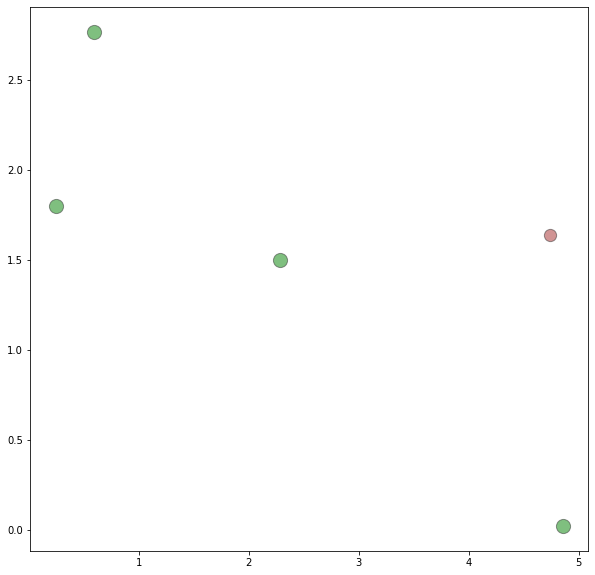

In [94]:
bestField = Field()
bestField.reset()
for p in path:    
    observation, r, cont, _ = bestField.step(p.action)
bestField.render()
    

In [27]:
bestField = Field()
field.reset()
for p in path:
    print(p.action)
    bestField.step(p.action)

[[0, 0.596063549808826, 0.7692665952802612], [3, 0.8181959165437431, 0.8223283499209483], [2, 0.5590637841029612, 0.8617419681721691], [1, 0.32804008589539313, 0.9481302643620644], [1, 0.3783043215292683, 0.12585352709217057], [2, 0.051668895096631084, 0.7474850071854474], [1, 0.30977541005525, 0.6239190240019675], [1, 0.02541389464904209, 0.6191367563862434], [2, 0.6596450424614562, 0.588016291120908], [3, 0.5379166193629675, 0.46279855865581365]]
X-coord0.596063549808826
Y-coord0.7692665952802612


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
for p in path[len(path)-1]:
    observation, reward, done, _ = field.step(p.action)
field.render()

In [8]:
field = Field()
field.reset()

test_agent = MCTS_Agent(state(field, [], None, False, True), field, 10000)
test_agent.mcts_traversal()


print(test_agent)


KeyboardInterrupt: 